<a href="https://colab.research.google.com/github/LoganReyn/Learning/blob/main/SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Skin Cancer Classification
ARTI 450: Deep Learning

Cody Lancaster & Logan Reynolds

Professor Gogolin

Fall 2024


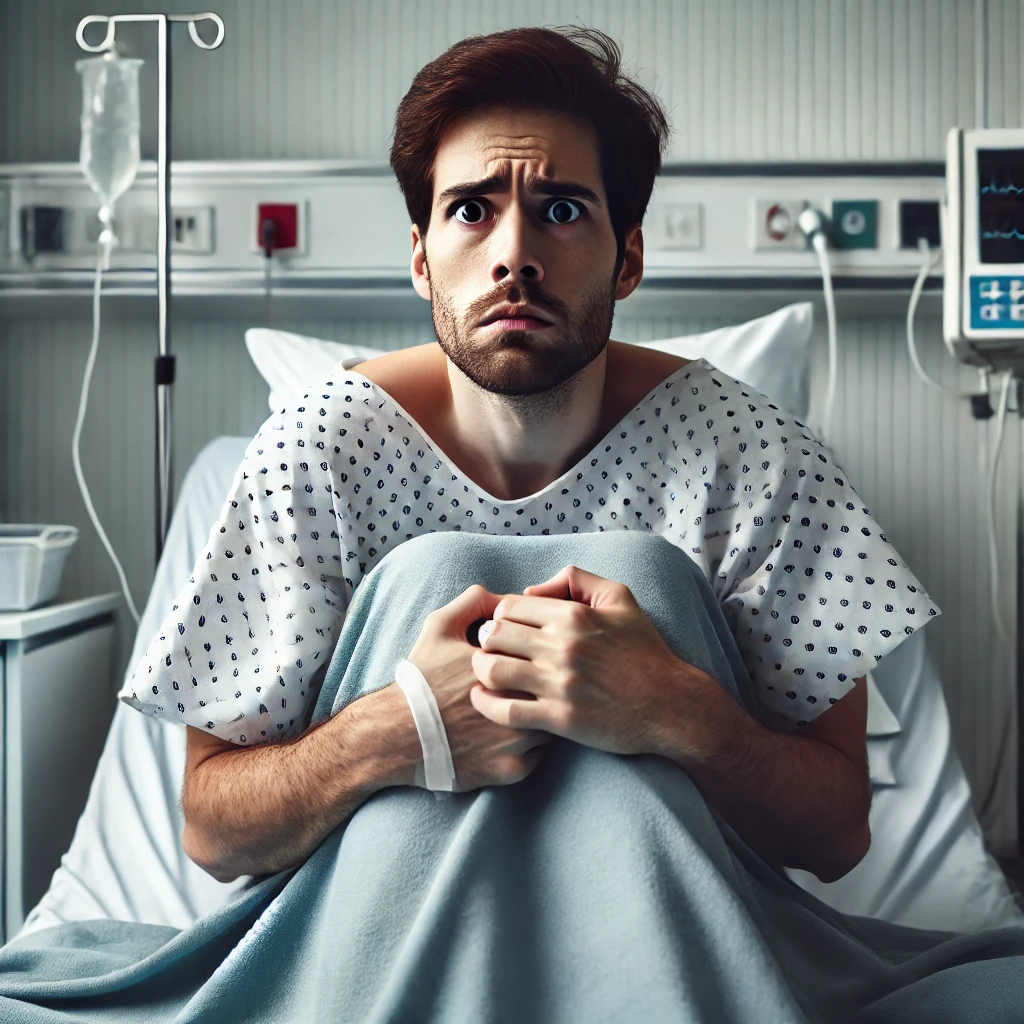


## Pre Modeling
  

> **Malignant:** This folder contains images of skin lesions that have been diagnosed as malignant, indicating the presence of skin cancer. These images can be used for training models to detect and differentiate malignant skin conditions.



> **Benign:** This folder includes images of benign skin lesions, which are non-cancerous and pose no immediate threat. These images are essential for training models to accurately distinguish between harmful and harmless skin conditions.


[DATASET](https://www.kaggle.com/datasets/shashanks1202/skin-cancer-dataset/data)


### New Ideas to Learn
* Dropout
* Data augmentation


### Steps Taken
1.   Load Data
2.   Augment images to create more
4.   Normalize pixel values
5.   Visualize class balance
6.   Prepare dataset for tensorflow
7.   Construct models and track metrics
7.   Compare models




In [ ]:
# @title Library Imports
from google.colab import drive
from tqdm import tqdm

import zipfile
import os
import cv2


from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
from sklearn.model_selection import train_test_split

In [ ]:
# @title Mount Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Set path to folder containing data to unzip
PATH_OF_UNZIPPED: str = "/content/drive/My Drive/Colab Notebooks/ProjectSkin/SkinCancer.zip" # @param {"type":"string"}

# Unzipping
zipfile.ZipFile(PATH_OF_UNZIPPED).extractall(path='/content')

# Verification
if "train_cancer" not in os.listdir(): raise Exception("Something has gone wrong.")

In [ ]:
# @title Set path to data after data unziped
PATH_OF_DATA = "/content/train_cancer" # @param {"type":"string"}


print("Path of Data:", PATH_OF_DATA)

Path of Data: /content/train_cancer


After unzipping content to current directory, there should be a new folder "train_cancer" in the files list. Let's view an example of each class.

In [ ]:
# @title Function for image viewing

def show_images_from_classes(directory, num_images_per_class=3):
  """
  Shows a specified number of images from each class within a directory.

  Args:
      directory: The path to the directory containing subfolders for each class.
      num_images_per_class: The number of images to show per class.
  """
  class_folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
  for class_folder in class_folders:
    class_path = os.path.join(directory, class_folder)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    random_image_files = random.sample(image_files, min(num_images_per_class, len(image_files)))

    print(f"Class: {class_folder}")
    plt.figure(figsize=(15, 5))
    for i, image_file in tqdm(enumerate(random_image_files), f"{class_folder}"):
      image_path = os.path.join(class_path, image_file)
      img = mpimg.imread(image_path)
      plt.subplot(1, num_images_per_class, i + 1)
      plt.imshow(img)
      plt.title(image_file)
      plt.axis('on')
    plt.show()

Class: benign


benign: 5it [00:00, 14.44it/s]


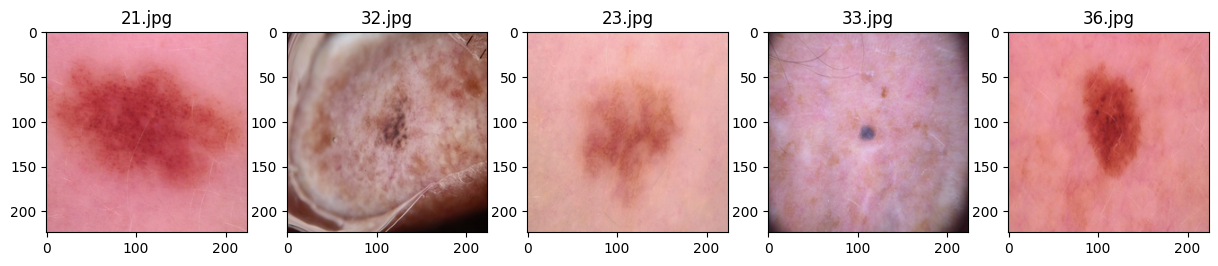

Class: malignant


malignant: 5it [00:00, 22.73it/s]


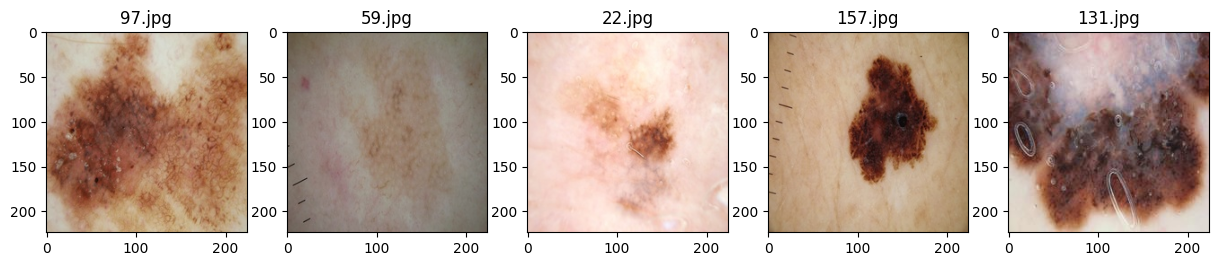

In [ ]:
# @title Using Function to view images
IMAGES_TO_SHOW_NUMBER = 5 # @param {type:"integer"}
show_images_from_classes(PATH_OF_DATA, IMAGES_TO_SHOW_NUMBER)

Above is 5 images of each class. The classes are benign and malignant. Benign meaning noncancerous, while malignant, cancerous.

In [ ]:
# Number of images in each class

for f in ["benign", "malignant"]:
  files = tuple(os.walk(f"{PATH_OF_DATA}/{f}"))[0][2]
  print(f, len(files))

benign 30
malignant 240


30 benign and 240 malignant. Not balanced.

In [ ]:
# @title Dataframe Creation

data = []
for class_folder in ["benign", "malignant"]:
    class_path = os.path.join(PATH_OF_DATA, class_folder)
    for image_file in tqdm(os.listdir(class_path), f"Processing {class_folder}"):
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB - cv2 loads images as BGR as default
            data.append([img_rgb, class_folder])

df = pd.DataFrame(data, columns=['image', 'label'])

Processing malignant: 100%|██████████| 240/240 [00:00<00:00, 818.86it/s]


In [ ]:
df.head(3)

image   label
0  [[[196, 111, 134], [199, 115, 139], [199, 113,...  benign
1  [[[214, 127, 161], [215, 130, 163], [215, 130,...  benign
2  [[[236, 175, 182], [232, 169, 177], [236, 174,...  benign

NOTE: Will have to apply a shuffle when partitioning for train test split.

## Data Augmentation

- Random Erasing
- Horizontal Flip
- Gaussian Blur
- Gaussian Noise
- Color Jitting
- Grid Distortion

**Steps Taken**

Created dataframe copies of master dataframe. Applied image augmentation to every image in copy of master dataframe.

**Reason for Data Augmentation**

Necessary to artificially increase the size of dataset as there is only 270 images. Can help prevent overfitting. May improve accuracy.

In [ ]:
# import torchvision.transforms.v2 as transforms # transforms is slower than transforms.v2
# import torch

In [ ]:
# @title Augmentation Methods

#!pip install Albumentations

import albumentations as A
from PIL import Image, ImageEnhance

# NOTE:
# in the future, it would be more seamless
# to use PyTorch's torchvision.transforms.v2

def applyFlip(image):
  return cv2.flip(image, 1) # flip horizontal

def applyGaussianBlur(image, kernel_size=(11, 11), sigma_x=0):
  """Applies Gaussian blur to an image."""
  return cv2.GaussianBlur(image, kernel_size, sigma_x)

def applyGaussianNoise(image, mean=0, stddev=0.1):
    """
    Applies Gaussian noise to an image.

    Args:
        image (numpy.ndarray): Input image.
        mean (float): Mean of the Gaussian noise.
        stddev (float): Standard deviation of the Gaussian noise.
    """
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise * 255, 0, 255).astype(np.uint8)
    return noisy_image


# Chat GPT Generated Garbage
def applyRandomErassing(image, sl=0.02, sh=0.4, rl=0.3, rh=3.3, value=0):
    """
    Randomly erases a rectangular region in the given image.

    Args:
        image (numpy.ndarray): The input image.
        sl (float): Minimum area ratio of the erased region.
        sh (float): Maximum area ratio of the erased region.
        rl (float): Minimum aspect ratio of the erased region.
        rh (float): Maximum aspect ratio of the erased region.
        value (int, tuple, or str): Erasing value. If int, it is used to erase all pixels.
                                    If tuple of length 3, it is used to erase R, G, B channels respectively.
                                    If 'random', erasing each pixel with random values.

    Returns:
        numpy.ndarray: The image with Random Erasing applied.
    """

    h, w, c = image.shape
    area = h * w

    for _ in range(100):  # Try 100 times to find a valid region
        target_area = np.random.uniform(sl, sh) * area
        aspect_ratio = np.random.uniform(rl, rh)

        er_w = int(np.sqrt(target_area * aspect_ratio))
        er_h = int(np.sqrt(target_area / aspect_ratio))

        if er_w < w and er_h < h:
            x1 = np.random.randint(0, w - er_w)
            y1 = np.random.randint(0, h - er_h)
            x2 = x1 + er_w
            y2 = y1 + er_h

            if value == 'random':
                image[y1:y2, x1:x2, :] = np.random.randint(0, 256, size=(er_h, er_w, c))
            else:
                image[y1:y2, x1:x2, :] = value
            return image

    return image


def applyColorJitter(image):
    """
    Applies color jitter to an image stored in array.

    Changes brightness, contrast, and color balance.
    """

    img = Image.fromarray(image)

    # Randomly adjust brightness, contrast, and color balance
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.5, 1.5))

    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(random.uniform(0.5, 1.5))

    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(random.uniform(0.5, 1.5))

    # Convert PIL Image back to NumPy array
    jittered_image_np = np.array(img)

    return jittered_image_np


def applyGridDistortion(image):
    """ Uses albumentations library """
    grid_distortion = A.GridDistortion(p=1.0)
    augmented = grid_distortion(image=image)
    return augmented['image']

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# @title Deep Copies of Dataframe
import copy


# NOTE: Shallow copies were not working
#       Needed to create deep copies of numpy arrays


# Make deep copies of the image data in each new dataframe
df_blurred = df.copy()
df_blurred['image'] = df_blurred['image'].apply(lambda x: copy.deepcopy(x))

df_flipped = df.copy()
df_flipped['image'] = df_flipped['image'].apply(lambda x: copy.deepcopy(x))

df_noisy = df.copy()
df_noisy['image'] = df_noisy['image'].apply(lambda x: copy.deepcopy(x))

df_erased = df.copy()
df_erased['image'] = df_erased['image'].apply(lambda x: copy.deepcopy(x))

df_color_jitted = df.copy()
df_color_jitted['image'] = df_color_jitted['image'].apply(lambda x: copy.deepcopy(x))

df_grid_distorted = df.copy()
df_grid_distorted['image'] = df_grid_distorted['image'].apply(lambda x: copy.deepcopy(x))

In [ ]:
# @title Application of Augmentation Methods

df_erased['image'] = df_erased['image'].apply(lambda x: applyRandomErassing(x))
df_flipped['image'] = df_flipped['image'].apply(lambda x: applyFlip(x))
df_blurred['image'] = df_blurred['image'].apply(lambda x: applyGaussianBlur(x))
df_noisy['image'] = df_noisy['image'].apply(lambda x: applyGaussianNoise(x))
df_color_jitted['image'] = df_color_jitted['image'].apply(lambda x: applyColorJitter(x))
df_grid_distorted['image'] = df_grid_distorted['image'].apply(lambda x: applyGridDistortion(x))

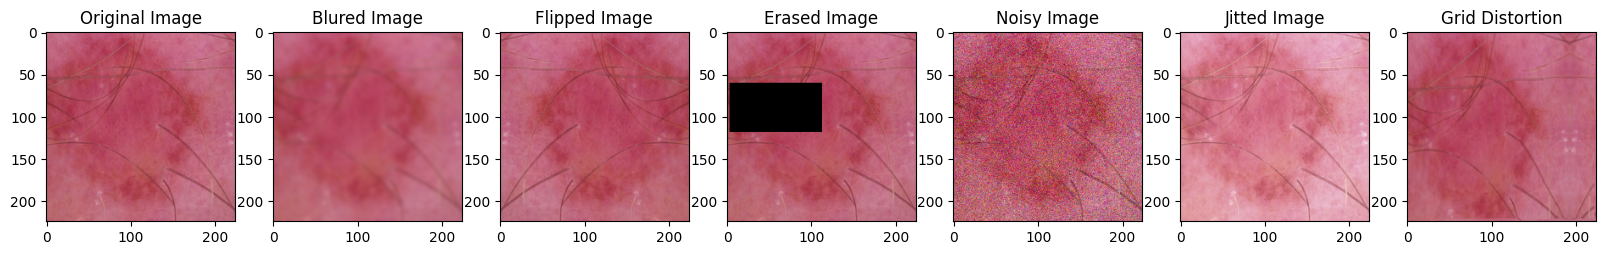

In [ ]:
# @title Comparison of Augmented Images

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

# Original image
axes[0].imshow(df['image'][0])
axes[0].set_title('Original Image')

# Blured image
axes[1].imshow(df_blurred['image'][0])
axes[1].set_title('Blured Image')

# Flipped image
axes[2].imshow(df_flipped['image'][0])
axes[2].set_title('Flipped Image')

# Erased image
axes[3].imshow(df_erased['image'][0])
axes[3].set_title('Erased Image')

# Noisy Image

axes[4].imshow(df_noisy['image'][0])
axes[4].set_title('Noisy Image')

# Jitted Image
axes[5].imshow(df_color_jitted['image'][0])
axes[5].set_title('Jitted Image')

# Jitted Image
axes[6].imshow(df_grid_distorted['image'][0])
axes[6].set_title('Grid Distortion')

plt.show()


6 different augmentation techniques shown above. Maybe not a good idea to create much artificial data. Lets shrink 6 to 3.

**Combo of augmentations**

- blurred & flipped
- noisy & grid distortion
- jitted & erased

In [ ]:
# @title Combo of Augmentations

# Blur then Flip
df_blurred_flipped = df_blurred.copy()
df_blurred_flipped['image'] = df_blurred_flipped['image'].apply(lambda x: copy.deepcopy(x))
df_blurred_flipped['image'] = df_blurred_flipped['image'].apply(lambda x: applyFlip(x))

# Grid Distortion then Noise
df_grid_noisy = df_grid_distorted.copy()
df_grid_noisy['image'] = df_grid_noisy['image'].apply(lambda x: copy.deepcopy(x))
df_grid_noisy['image'] = df_grid_noisy['image'].apply(lambda x: applyGaussianNoise(x))

# Jitted then Erased
df_jitted_erased = df_color_jitted.copy()
df_jitted_erased['image'] = df_jitted_erased['image'].apply(lambda x: copy.deepcopy(x))
df_jitted_erased['image'] = df_jitted_erased['image'].apply(lambda x: applyRandomErassing(x))

# CLEAN UP
del df_blurred
del df_flipped
del df_erased
del df_color_jitted
del df_grid_distorted

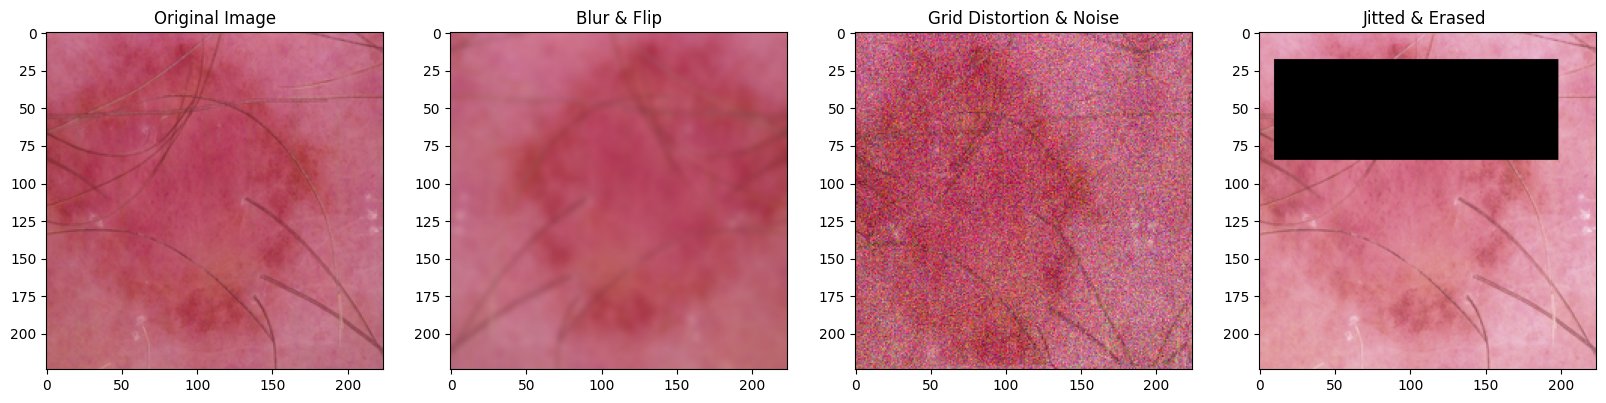

In [ ]:
# @title "New" Augmentations Comparison

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(df['image'][0])
axes[0].set_title('Original Image')

# Blured Blur && Flip
axes[1].imshow(df_blurred_flipped['image'][0])
axes[1].set_title('Blur & Flip')

# Grid Distortion && Noise
axes[2].imshow(df_grid_noisy['image'][0])
axes[2].set_title('Grid Distortion & Noise')

# Jitted && Erased
axes[3].imshow(df_jitted_erased['image'][0])
axes[3].set_title('Jitted & Erased ')

plt.show()

These look good enough to concate into one dataframe.

In [ ]:
masterDf = pd.concat([df, df_blurred_flipped, df_grid_noisy, df_jitted_erased], ignore_index=True)

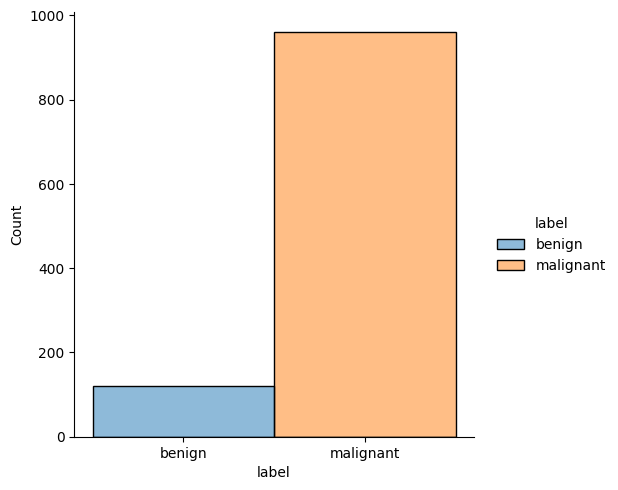

In [ ]:
sns.displot(data=masterDf, x="label", hue="label")

Imbalanced. Not easy to work with.

## Prepocessing

In [ ]:
# @title Encode label: "Malignant" = 1, "Benign" = 0

masterDf['label'] = masterDf['label'].apply(lambda x: 1 if x == "malignant" else 0)

In [ ]:
# @title Train Test Split 80 / 20

X = masterDf['image'].tolist()  # Convert image data column to a list
y = masterDf['label']

# did shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4_000, shuffle=True, stratify=y)

In [ ]:
# @title Reshaping

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

X_train.shape

(864, 224, 224, 3)

Images are 224 x 224. There is 864 images total and they are RGB.

In [ ]:
# @title Normilization of Pixel Values 0 to 1

# Pixel Values Before: [0 - 255]

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Pixel Values After: [0 - 1]

# Modeling

- Validation used 20% of testing


In [ ]:
# @title Clear Up TensorFlow

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

tf.keras.backend.clear_session()

In [ ]:
# @title Function for visualization "display_training_graphs"

def display_training_graphs(history):
  """

  """
  myHistory: dict = history.history

  # accuracy
  binary_accuracy = myHistory['binary_accuracy']
  val_binary_accuracy = myHistory['val_binary_accuracy']


  # loss
  loss = myHistory['loss']
  val_loss = myHistory['val_loss']


  # precision
  precision = myHistory['precision']
  val_precision = myHistory['val_precision']


  # recall
  recall = myHistory['recall']
  val_recall = myHistory['val_recall']


  epochs = range(1, len(binary_accuracy) + 1)


  # Plotting accuracy
  plt.figure(figsize=(12, 8))
  plt.subplot(2, 2, 1)
  plt.plot(epochs, binary_accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_binary_accuracy, 'r', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(2, 2, 2)
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plotting precision
  plt.subplot(2, 2, 3)
  plt.plot(epochs, precision, 'b', label='Training Precision')
  plt.plot(epochs, val_precision, 'r', label='Validation Precision')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()

  # Plotting recall
  plt.subplot(2, 2, 4)
  plt.plot(epochs, recall, 'b', label='Training Recall')
  plt.plot(epochs, val_recall, 'r', label='Validation Recall')
  plt.title('Training and Validation Recall')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()
  plt.tight_layout()
  plt.show()


In [ ]:
# @title Function for ROC & AUC Graph "output_roc_curve"

def output_roc_curve(y_test, y_pred_prob):
    """ Needs sklearn row_curve and auc"""
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve with shaded AUC
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal for random performance
    plt.fill_between(fpr, tpr, alpha=0.2, color='blue')  # Shade AUC

    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# @title Model One CNN (contains dropout)

modelOne = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # 50% of neurons dropout
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# @title Model One Compile & Training

EPOCHS = 5 # @param {type: "integer"}

# Compile the model
modelOne.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(), Recall(), Precision()])

# Train the model
historyOne = modelOne.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - binary_accuracy: 0.8447 - loss: 0.6607 - precision: 0.9006 - recall: 0.9343 - val_binary_accuracy: 0.8786 - val_loss: 0.4012 - val_precision: 0.8786 - val_recall: 1.0000
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - binary_accuracy: 0.8803 - loss: 0.3492 - precision: 0.8803 - recall: 1.0000 - val_binary_accuracy: 0.8786 - val_loss: 0.3044 - val_precision: 0.8786 - val_recall: 1.0000
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - binary_accuracy: 0.8832 - loss: 0.2503 - precision: 0.8831 - recall: 1.0000 - val_binary_accuracy: 0.8786 - val_loss: 0.3547 - val_precision: 0.8786 - val_recall: 1.0000
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - binary_accuracy: 0.9059 - loss: 0.2928 - precision: 0.9076 - recall: 0.9959 - val_binary_accuracy: 0.8960 - val_loss: 0.2490 - val_precision: 0.8941 - val_recall: 1.0000
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - binary_accuracy: 0.8901 - loss: 0.2527 - precision: 0.8900 - 

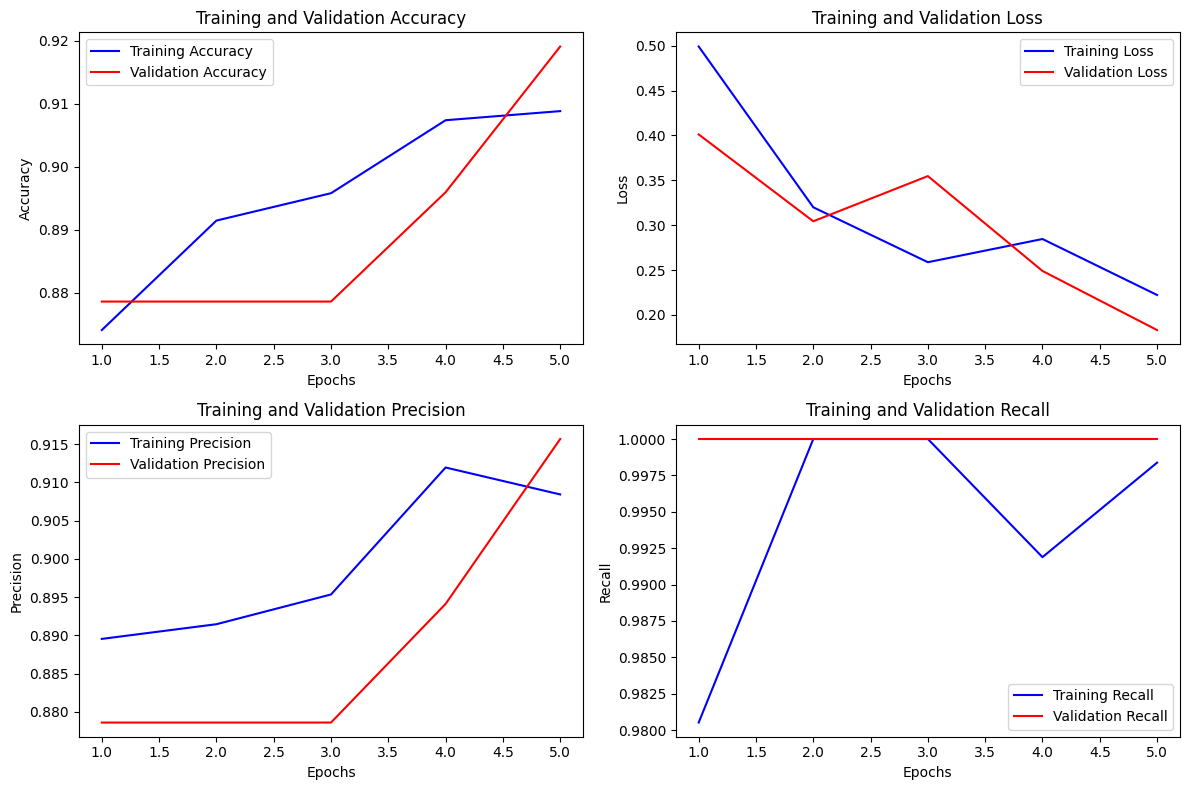

<Figure size 640x480 with 0 Axes>

In [ ]:
# @title Model One Graphs
display_training_graphs(historyOne)

The accuracy and precision had upward trends with each epoch. This is a good thing, and it was observed for both the training and validation. The downward trend over epochs for loss was also a good thing. Again, this held true for the training and validation. The recall flatlined for the validation and the training recall was also close to 1.

In [ ]:
# @title Model One Testing

test_loss, test_binac, test_recall, test_precision = modelOne.evaluate(X_test, y_test, verbose=2)

7/7 - 7s - 1s/step - binary_accuracy: 0.9398 - loss: 0.2164 - precision: 0.9366 - recall: 1.0000


This model had 89% accuracy on the training and 93% accuracy on the testing.

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 883ms/step


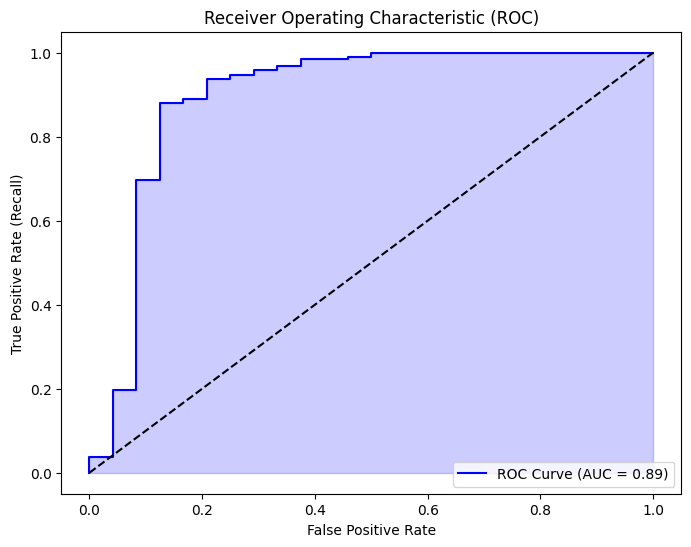

In [ ]:
# @title Model One ROC & AUC
y_pred_prob = modelOne.predict(X_test)
output_roc_curve(y_test, y_pred_prob)

In general:
- AUC of 0.5: Model has no predictive ability (equivalent to random guessing).
- AUC of 0.7 - 0.8: Model has acceptable predictive ability.
- AUC of 0.8 - 0.9: Model has excellent predictive ability.
- AUC of 0.9 or above: Model has outstanding predictive ability.

In [ ]:
# @title Model Two CNN (no dropout)

modelTwo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# @title Model Two Compile & Training

EPOCHS = 5 # @param {type: "integer"}

# Compile the model
modelTwo.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(), Recall(), Precision()])



# Train the model
historyTwo = modelTwo.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=0.2)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - binary_accuracy: 0.7571 - loss: 0.6296 - precision_1: 0.8853 - recall_1: 0.8419 - val_binary_accuracy: 0.8786 - val_loss: 0.3644 - val_precision_1: 0.8786 - val_recall_1: 1.0000
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - binary_accuracy: 0.9050 - loss: 0.2839 - precision_1: 0.9064 - recall_1: 0.9979 - val_binary_accuracy: 0.9133 - val_loss: 0.2412 - val_precision_1: 0.9102 - val_recall_1: 1.0000
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - binary_accuracy: 0.9354 - loss: 0.1892 - precision_1: 0.9421 - recall_1: 0.9899 - val_binary_accuracy: 0.9133 - val_loss: 0.1881 - val_precision_1: 0.9152 - val_recall_1: 0.9934
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - binary_accuracy: 0.9289 - loss: 0.1851 - precision_1: 0.9576 - recall_1: 0.9638 - val_binary_accuracy: 0.9133 - val_loss: 0.2117 - val_precision_1: 0.9152 - val_recall_1: 0.9934
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - binary_accuracy: 0.9487 - loss

In [ ]:
# @title Model Two Test

test_loss, test_binac, test_recall, test_precision = modelTwo.evaluate(X_test, y_test, verbose=2)

7/7 - 10s - 1s/step - binary_accuracy: 0.8843 - loss: 0.4656 - precision_1: 0.8995 - recall_1: 0.9792


Model Two had 94% accuracy on training and 88% on testing. This indicates the model is more overfit than the first. This is no surprise as dropout can improve generalization. Model two did not contain a dropout layer.

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


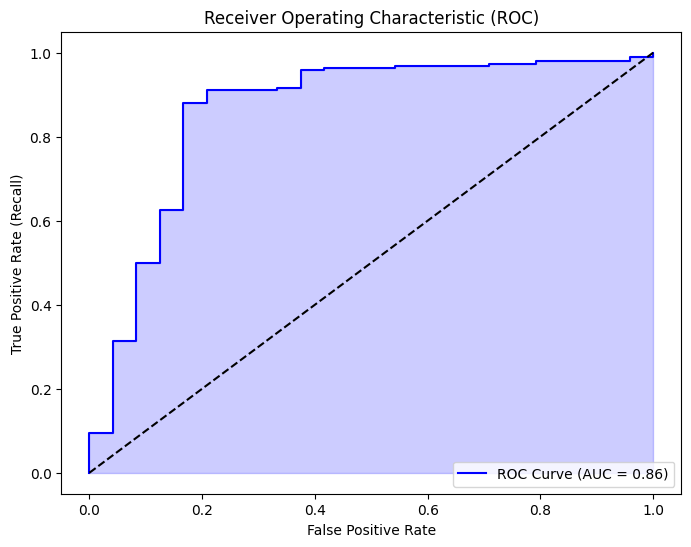

In [ ]:
# @title Model Two ROC & AUC
y_pred_prob = modelTwo.predict(X_test)
output_roc_curve(y_test, y_pred_prob)

Area Under Curve (AUC) is worse than the first model. Again, no surprise as the binary_accuracy was lower than that of the first model.

## Discussion

For future explorations, we could investigate the potential benefits of employing transfer learning. By leveraging pre-trained models, we might achieve improved performance with limited data. Additionally, experimenting with black and white image inputs could provide insights into whether color information is crucial for accurate classification or if grayscale representation simplifies the model's learning process without sacrificing accuracy.

# Conclusion

This project explored the application of Convolutional Neural Networks (CNNs) for the classification of skin lesions as benign or malignant. Through data augmentation techniques like blurring, flipping, and noise injection, we addressed the initial dataset's imbalance and expanded its size, potentially improving model generalization. Two CNN models were developed and compared. Model One, incorporating a dropout layer, demonstrated promising performance with higher accuracy on the test set and a superior AUC score, suggesting better generalization compared to Model Two, which lacked dropout.

While these initial results are encouraging, there are avenues for future exploration to further enhance the model's accuracy and robustness. Investigating the potential benefits of transfer learning by leveraging pre-trained models could be a valuable next step. Furthermore, exploring the impact of using black and white images instead of color images might yield insights into the significance of color information for accurate classification.

Ultimately, this project highlighted the potential of CNNs for automated skin cancer detection. Further research and refinements to the model could contribute to the development of a valuable tool for assisting medical professionals in early diagnosis and improving patient outcomes.